In [50]:
import os
import random

data_root = '/home/helen/dataset/kagglecatsanddogs_5340/PetImages'

cat_img_paths = [os.path.join(data_root, 'Cat', filename) for filename in os.listdir(os.path.join(data_root, 'Cat')) if filename.lower().endswith('.jpg')]
dog_img_paths = [os.path.join(data_root, 'Dog', filename) for filename in os.listdir(os.path.join(data_root, 'Dog')) if filename.lower().endswith('.jpg')]

import numpy as np
trn_ids = np.random.randint(25000, size=6)
random_subset = np.random.randint(24994, size=500)

train_img_paths = []
for id in trn_ids:
    if id > len(cat_img_paths):
        train_img_paths.append(dog_img_paths[id - 12501])
    else:
        train_img_paths.append(cat_img_paths[id])

In [51]:
trn_ids

array([23813,  3645, 17709, 18103,  2323,  1372])

In [52]:
len(cat_img_paths), len(dog_img_paths)

(12499, 12499)

In [53]:
train_img_paths = []
for id in trn_ids:
    if id > len(cat_img_paths):
        train_img_paths.append(dog_img_paths[id - 12501])
    else:
        train_img_paths.append(cat_img_paths[id])

valid_img_paths = []
for id in random_subset:
    if id > len(cat_img_paths):
        valid_img_paths.append(dog_img_paths[id - 12501])
    else:
        valid_img_paths.append(cat_img_paths[id])


In [54]:
train_img_paths

['/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Dog/11946.jpg',
 '/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Cat/12098.jpg',
 '/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Dog/3462.jpg',
 '/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Dog/3304.jpg',
 '/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Cat/8189.jpg',
 '/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Cat/532.jpg']

In [55]:
import os
import glob
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

class CatsDogsDataset(Dataset):
    def __init__(self, img_path, transform=None):       
          self.transform = transform
          # 将训练集提前准备好了的~
          self.image_paths = img_path #glob.glob(os.path.join(root_dir, '*.jpg'))
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label = 1 if 'Dog' in img_path else 0
        
        return image, label

# 定义图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # 会除以255的
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 创建数据集
train_dataset = CatsDogsDataset(img_path=train_img_paths, transform=transform)

# 创建数据加载器
batch_size = 6
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [56]:
all_imgs = cat_img_paths + dog_img_paths

In [57]:
# valid_dataset = CatsDogsDataset(img_path=valid_img_paths, transform=transform)
valid_dataset = CatsDogsDataset(img_path=all_imgs, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [59]:
len(valid_dataset)

24998

In [10]:
print(len(train_loader))
x,y = next(iter(train_loader))
print(x.shape,y.shape,y)
train_dataset.image_paths

1
torch.Size([6, 3, 224, 224]) torch.Size([6]) tensor([1, 1, 0, 0, 0, 1])


['/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Dog/7112.jpg',
 '/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Cat/7618.jpg',
 '/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Cat/11733.jpg',
 '/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Dog/1569.jpg',
 '/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Dog/2612.jpg',
 '/home/helen/dataset/kagglecatsanddogs_5340/PetImages/Cat/9660.jpg']

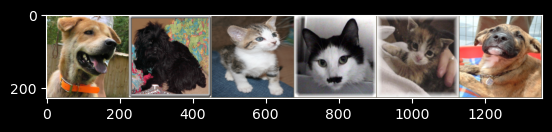

In [60]:
import numpy as np
import torch
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

import matplotlib.pyplot as plt
import torchvision
def imshow(img):
    # img = img / 2 + 0.5 # 反标准化
    # (x - u) / std tensor.sub_(mean).div_(std)
    # hhhh，我竟然成功了！！！加鸡腿！！！
    denorm_img = img.mul(torch.tensor(imagenet_std).reshape(-1,1,1)) + torch.tensor(imagenet_mean).reshape(-1,1,1)
    npimg = denorm_img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imshow(torchvision.utils.make_grid(x))

In [12]:
from model import vgg
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model_name = "vgg16"
net = vgg(model_name=model_name, num_classes=2, init_weights=True)
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
epochs = 40

In [13]:
#查看模型所占用的内存大小
# 打印模型的显存占用情况
print(f"Model GPU memory usage: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")

Model GPU memory usage: 513.07 MB


In [16]:
# %%time
import tqdm
import sys
import torch

train_steps = len(train_loader)
val_num = len(valid_dataset)
for epoch in range(10):
    net.train()
    running_loss = 0.0
    # 遍历数据加载器
    for batch_images, batch_labels in train_loader:
        # 在这里执行训练或验证的操作
        optimizer.zero_grad()
        outputs = net(batch_images.to(device))
        loss = loss_function(outputs, batch_labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 训练10个epoch再来看看
    net.eval()
    acc = 0.0
    with torch.no_grad():
        # val_bar = tqdm(valid_loader, file=sys.stdout)
        for val_imgs, val_lbls in valid_loader:
            outputs = net(val_imgs.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_lbls.to(device)).sum().item()
    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
            (epoch + 1, running_loss / train_steps, val_accurate))

[epoch 1] train_loss: 0.353  val_accuracy: 0.492
[epoch 2] train_loss: 0.011  val_accuracy: 0.492
[epoch 3] train_loss: 0.000  val_accuracy: 0.492
[epoch 4] train_loss: 0.000  val_accuracy: 0.492
[epoch 5] train_loss: 0.000  val_accuracy: 0.492
[epoch 6] train_loss: 0.000  val_accuracy: 0.492
[epoch 7] train_loss: 0.000  val_accuracy: 0.492
[epoch 8] train_loss: 0.000  val_accuracy: 0.492
[epoch 9] train_loss: 0.000  val_accuracy: 0.492
[epoch 10] train_loss: 0.000  val_accuracy: 0.492


- 这里是从头训练的vgg16，前后都是一个学习率，然后模型参数有500M+，参数较多的
- 这里没有预训练权重，没有冻结特征层！！
- 然后明明只有6个图像，怎么都要训练那么久，是全连接层拉低了速度吗？

In [27]:
pip install torchsummary

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [17]:
# 我去，怎么输出是5个类别，明明只有2个类别啊，难怪acc 50%
# 1个亿的参数量：其中1亿都在那个全连接层那里了
from torchsummary import summary
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## 结论
1. 没有使用预训练权重：网络过拟合
    - loss为0； acc不再增加
2. 那Radek点6个样本，40个epoch都没有过拟合，loss都在下降的秘诀在哪里？
    - 学习率？图像增强？迁移学习？？？

# Radek‘s VGG

In [61]:
# 参数有差别：Radek没有全连接，做了网络的修改
import torch.nn as nn
import torch.optim as optim

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            # nn.AdaptiveAvgPool2d(1),
            nn.Linear(512, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes),
            nn.BatchNorm1d(num_classes),
            nn.Softmax(dim=1)
        )
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.features(x)
        # N x 512 x 7 x 7
        x = self.maxpool(x)
        x = torch.flatten(x, start_dim=1)
        # N x 512*7*7
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                # nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # nn.init.xavier_uniform_(m.weight)
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_features(cfg: list):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg(model_name="vgg19", **kwargs):
    assert model_name in cfgs, "Warning: model number {} not in cfgs dict!".format(model_name)
    cfg = cfgs[model_name]

    model = VGG(make_features(cfg), **kwargs)
    return model

In [36]:
m = nn.AdaptiveAvgPool2d(1)
input = torch.randn(6, 512, 7, 7)
xx = m(input)
output = torch.flatten(xx, start_dim=1)
output.shape, 6*512, xx.shape

(torch.Size([6, 512]), 3072, torch.Size([6, 512, 1, 1]))

In [13]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_name = "vgg16"
net = vgg(model_name=model_name, num_classes=2, init_weights=True)
net.to(device)

# model_weight_path = ""
# assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
# net.load_state_dict(torch.load(model_weight_path, map_location=device))

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
epochs = 40

In [14]:
#查看模型所占用的内存大小
# 打印模型的显存占用情况
print(f"Model GPU memory usage: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")

Model GPU memory usage: 65.12 MB


In [39]:
# 我去，怎么输出是5个类别，明明只有2个类别啊，难怪acc 50%
# 1个亿的参数量：其中1亿都在那个全连接层那里了
from torchsummary import summary
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [15]:
# %%time
import tqdm
import sys
import torch

train_steps = len(train_loader)
val_num = len(valid_dataset)
for epoch in range(10):
    net.train()
    running_loss = 0.0
    # 遍历数据加载器
    for batch_images, batch_labels in train_loader:
        # 在这里执行训练或验证的操作
        optimizer.zero_grad()
        outputs = net(batch_images.to(device))
        loss = loss_function(outputs, batch_labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 训练10个epoch再来看看
    net.eval()
    acc = 0.0
    with torch.no_grad():
        # val_bar = tqdm(valid_loader, file=sys.stdout)
        for val_imgs, val_lbls in valid_loader:
            outputs = net(val_imgs.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_lbls.to(device)).sum().item()
    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
            (epoch + 1, running_loss / train_steps, val_accurate))

[epoch 1] train_loss: 0.797  val_accuracy: 0.486
[epoch 2] train_loss: 0.498  val_accuracy: 0.498
[epoch 3] train_loss: 0.425  val_accuracy: 0.506
[epoch 4] train_loss: 0.436  val_accuracy: 0.504
[epoch 5] train_loss: 0.414  val_accuracy: 0.504
[epoch 6] train_loss: 0.411  val_accuracy: 0.504
[epoch 7] train_loss: 0.405  val_accuracy: 0.504
[epoch 8] train_loss: 0.405  val_accuracy: 0.504
[epoch 9] train_loss: 0.405  val_accuracy: 0.504
[epoch 10] train_loss: 0.405  val_accuracy: 0.504


### 去掉全连接，网络有在积极训练
- 最后loss不再下降了，why？精度也不再增加了
- 50% 跟随机乱猜差不多哦，基本没啥意义的训练哦？

In [27]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_name = "vgg16"
net = vgg(model_name=model_name, num_classes=2, init_weights=True)
net.to(device)

model_weight_path = "/home/helen/dataset/vgg16-397923af.pth"
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
# net.features.load_state_dict(torch.load(model_weight_path, map_location=device))
pre_weights = torch.load(model_weight_path, map_location=device)
del_key = []
for key, _ in pre_weights.items():
    if "classifier" in key:
        del_key.append(key)

for key in del_key:
    del pre_weights[key]

missing_keys, unexpected_keys = net.load_state_dict(pre_weights, strict=False)
# print("[missing_keys]:", *missing_keys, sep="\n")
# print("[unexpected_keys]:", *unexpected_keys, sep="\n")

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
epochs = 40

[missing_keys]:
classifier.0.weight
classifier.0.bias
classifier.1.weight
classifier.1.bias
classifier.1.running_mean
classifier.1.running_var
classifier.3.weight
classifier.3.bias
classifier.4.weight
classifier.4.bias
classifier.4.running_mean
classifier.4.running_var
[unexpected_keys]:


- 不要分类层，只要特征层，也就是backbone

In [25]:
pre_weights = torch.load(model_weight_path, map_location=device)
del_key = []
for key, _ in pre_weights.items():
    if "classifier" in key:
        del_key.append(key)

for key in del_key:
    del pre_weights[key]

missing_keys, unexpected_keys = net.load_state_dict(pre_weights, strict=False)
print("[missing_keys]:", *missing_keys, sep="\n")
print("[unexpected_keys]:", *unexpected_keys, sep="\n")

[missing_keys]:
classifier.0.weight
classifier.0.bias
classifier.1.weight
classifier.1.bias
classifier.1.running_mean
classifier.1.running_var
classifier.3.weight
classifier.3.bias
classifier.4.weight
classifier.4.bias
classifier.4.running_mean
classifier.4.running_var
[unexpected_keys]:


In [23]:
for key, value in pre_weights.items():
    print(key, value.shape)

features.0.weight torch.Size([64, 3, 3, 3])
features.0.bias torch.Size([64])
features.2.weight torch.Size([64, 64, 3, 3])
features.2.bias torch.Size([64])
features.5.weight torch.Size([128, 64, 3, 3])
features.5.bias torch.Size([128])
features.7.weight torch.Size([128, 128, 3, 3])
features.7.bias torch.Size([128])
features.10.weight torch.Size([256, 128, 3, 3])
features.10.bias torch.Size([256])
features.12.weight torch.Size([256, 256, 3, 3])
features.12.bias torch.Size([256])
features.14.weight torch.Size([256, 256, 3, 3])
features.14.bias torch.Size([256])
features.17.weight torch.Size([512, 256, 3, 3])
features.17.bias torch.Size([512])
features.19.weight torch.Size([512, 512, 3, 3])
features.19.bias torch.Size([512])
features.21.weight torch.Size([512, 512, 3, 3])
features.21.bias torch.Size([512])
features.24.weight torch.Size([512, 512, 3, 3])
features.24.bias torch.Size([512])
features.26.weight torch.Size([512, 512, 3, 3])
features.26.bias torch.Size([512])
features.28.weight t

In [28]:
# %%time
import tqdm
import sys
import torch

train_steps = len(train_loader)
val_num = len(valid_dataset)
for epoch in range(10):
    net.train()
    running_loss = 0.0
    # 遍历数据加载器
    for batch_images, batch_labels in train_loader:
        # 在这里执行训练或验证的操作
        optimizer.zero_grad()
        outputs = net(batch_images.to(device))
        loss = loss_function(outputs, batch_labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 训练10个epoch再来看看
    net.eval()
    acc = 0.0
    with torch.no_grad():
        # val_bar = tqdm(valid_loader, file=sys.stdout)
        for val_imgs, val_lbls in valid_loader:
            outputs = net(val_imgs.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_lbls.to(device)).sum().item()
    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
            (epoch + 1, running_loss / train_steps, val_accurate))

[epoch 1] train_loss: 0.777  val_accuracy: 0.706
[epoch 2] train_loss: 0.438  val_accuracy: 0.788
[epoch 3] train_loss: 0.390  val_accuracy: 0.840
[epoch 4] train_loss: 0.385  val_accuracy: 0.856
[epoch 5] train_loss: 0.385  val_accuracy: 0.870
[epoch 6] train_loss: 0.385  val_accuracy: 0.860
[epoch 7] train_loss: 0.384  val_accuracy: 0.858
[epoch 8] train_loss: 0.384  val_accuracy: 0.850
[epoch 9] train_loss: 0.384  val_accuracy: 0.844
[epoch 10] train_loss: 0.384  val_accuracy: 0.832


- 载入了预训练权重之后，acc有明显上升的了

### 冻结backbone再看看，同时VGG的初始化也改了的
- 综上，迁移学习+冻结backbone可以实现和Radek一样的效果了

In [62]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_name = "vgg16"
net = vgg(model_name=model_name, num_classes=2, init_weights=True)
net.to(device)

model_weight_path = "/home/helen/dataset/vgg16-397923af.pth"
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
# net.features.load_state_dict(torch.load(model_weight_path, map_location=device))
pre_weights = torch.load(model_weight_path, map_location=device)
del_key = []
for key, _ in pre_weights.items():
    if "classifier" in key:
        del_key.append(key)

for key in del_key:
    del pre_weights[key]

missing_keys, unexpected_keys = net.load_state_dict(pre_weights, strict=False)
# print("[missing_keys]:", *missing_keys, sep="\n")
# print("[unexpected_keys]:", *unexpected_keys, sep="\n")

loss_function = nn.CrossEntropyLoss()

for para in net.features:
    para.requires_grad_(False)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
# epochs = 40

In [39]:
for p in net.features.named_parameters():
    print(p[0], p[1].requires_grad)
for p in net.classifier.named_parameters():
    print(p[0], p[1].requires_grad)

0.weight False
0.bias False
2.weight False
2.bias False
5.weight False
5.bias False
7.weight False
7.bias False
10.weight False
10.bias False
12.weight False
12.bias False
14.weight False
14.bias False
17.weight False
17.bias False
19.weight False
19.bias False
21.weight False
21.bias False
24.weight False
24.bias False
26.weight False
26.bias False
28.weight False
28.bias False
0.weight True
0.bias True
1.weight True
1.bias True
3.weight True
3.bias True
4.weight True
4.bias True


In [49]:
# %%time
import tqdm
import sys
import torch

train_steps = len(train_loader)
val_num = len(valid_dataset)
for epoch in range(40):
    net.train()
    running_loss = 0.0
    # 遍历数据加载器
    for batch_images, batch_labels in train_loader:
        # 在这里执行训练或验证的操作
        optimizer.zero_grad()
        outputs = net(batch_images.to(device))
        loss = loss_function(outputs, batch_labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 训练10个epoch再来看看
    net.eval()
    acc = 0.0
    with torch.no_grad():
        # val_bar = tqdm(valid_loader, file=sys.stdout)
        for val_imgs, val_lbls in valid_loader:
            outputs = net(val_imgs.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_lbls.to(device)).sum().item()
    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
            (epoch + 1, running_loss / train_steps, val_accurate))

[epoch 1] train_loss: 0.793  val_accuracy: 0.496
[epoch 2] train_loss: 0.422  val_accuracy: 0.496
[epoch 3] train_loss: 0.402  val_accuracy: 0.498
[epoch 4] train_loss: 0.394  val_accuracy: 0.504
[epoch 5] train_loss: 0.391  val_accuracy: 0.522
[epoch 6] train_loss: 0.388  val_accuracy: 0.558
[epoch 7] train_loss: 0.387  val_accuracy: 0.588
[epoch 8] train_loss: 0.386  val_accuracy: 0.636
[epoch 9] train_loss: 0.385  val_accuracy: 0.684
[epoch 10] train_loss: 0.385  val_accuracy: 0.736
[epoch 11] train_loss: 0.384  val_accuracy: 0.766
[epoch 12] train_loss: 0.384  val_accuracy: 0.788
[epoch 13] train_loss: 0.384  val_accuracy: 0.808
[epoch 14] train_loss: 0.384  val_accuracy: 0.844
[epoch 15] train_loss: 0.383  val_accuracy: 0.878
[epoch 16] train_loss: 0.383  val_accuracy: 0.884
[epoch 17] train_loss: 0.383  val_accuracy: 0.902
[epoch 18] train_loss: 0.383  val_accuracy: 0.902
[epoch 19] train_loss: 0.383  val_accuracy: 0.900
[epoch 20] train_loss: 0.383  val_accuracy: 0.902
[epoch 21

In [63]:
# %%time
import tqdm
import sys
import torch

train_steps = len(train_loader)
val_num = len(valid_dataset)
for epoch in range(20):
    net.train()
    running_loss = 0.0
    # 遍历数据加载器
    for batch_images, batch_labels in train_loader:
        # 在这里执行训练或验证的操作
        optimizer.zero_grad()
        outputs = net(batch_images.to(device))
        loss = loss_function(outputs, batch_labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 训练10个epoch再来看看
    net.eval()
    acc = 0.0
    with torch.no_grad():
        # val_bar = tqdm(valid_loader, file=sys.stdout)
        for val_imgs, val_lbls in valid_loader:
            outputs = net(val_imgs.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_lbls.to(device)).sum().item()
    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
            (epoch + 1, running_loss / train_steps, val_accurate))

/home/zhr/miniconda3/envs/fastai2/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[epoch 1] train_loss: 0.736  val_accuracy: 0.547
[epoch 2] train_loss: 0.423  val_accuracy: 0.570
[epoch 3] train_loss: 0.397  val_accuracy: 0.611
[epoch 4] train_loss: 0.390  val_accuracy: 0.660
[epoch 5] train_loss: 0.386  val_accuracy: 0.710
[epoch 6] train_loss: 0.385  val_accuracy: 0.751
[epoch 7] train_loss: 0.384  val_accuracy: 0.791
[epoch 8] train_loss: 0.384  val_accuracy: 0.822
[epoch 9] train_loss: 0.384  val_accuracy: 0.850
[epoch 10] train_loss: 0.384  val_accuracy: 0.873
[epoch 11] train_loss: 0.383  val_accuracy: 0.891
[epoch 12] train_loss: 0.383  val_accuracy: 0.906
[epoch 13] train_loss: 0.383  val_accuracy: 0.915
[epoch 14] train_loss: 0.383  val_accuracy: 0.923
[epoch 15] train_loss: 0.383  val_accuracy: 0.929
[epoch 16] train_loss: 0.383  val_accuracy: 0.934
[epoch 17] train_loss: 0.383  val_accuracy: 0.939
[epoch 18] train_loss: 0.383  val_accuracy: 0.942
[epoch 19] train_loss: 0.383  val_accuracy: 0.944
[epoch 20] train_loss: 0.383  val_accuracy: 0.946
